In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
import fastai.basics as fai
import fastai.collab as fc
import fastai.tabular as ft

from pathlib import Path
from shutil import copyfile
import random
import gc

import torch
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.utils as utils
import torchvision.models
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
path = Path('AnimeRatings/')

In [4]:
path

PosixPath('AnimeRatings')

In [5]:
path.ls()

[PosixPath('AnimeRatings/rating.csv'),
 PosixPath('AnimeRatings/anime.csv'),
 PosixPath('AnimeRatings/anime-recommendations-database.zip')]

In [6]:
ratings = pd.read_csv(path/"rating.csv")

In [7]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Quitamos los -1's, porque, al menos por el momento, no nos sirven de nada (esto se podría investigar. Quizás se podría cambiar el -1 por algo como el promedio de ese anime, o algo entre el promedio de ese anime y el promedio global, porque si no calificas algo que sí viste es porque quizás no te impresionó suficiente)

In [8]:
ratings = ratings[ratings['rating'] != -1]

In [9]:
ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [10]:
animes = pd.read_csv("AnimeRatings/anime.csv")

In [11]:
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [12]:
ratings = ratings.merge(animes[["anime_id", "name"]])

In [13]:
ratings.head()

,user_id,anime_id,rating,name
0,1,8074,10,Highschool of the Dead
1,3,8074,6,Highschool of the Dead
2,5,8074,2,Highschool of the Dead
3,12,8074,6,Highschool of the Dead
4,14,8074,6,Highschool of the Dead


In [14]:
data = fc.CollabDataBunch.from_df(ratings, seed=666, valid_pct=0.1, item_name="name")

In [15]:
data.show_batch()

user_id,name,target
26036,Kaze no Stigma,9.0
10049,Aki-Sora: Yume no Naka,5.0
65509,Hellsing,9.0
24890,Gedo Senki,9.0
65958,"Akagami no Shirayuki-hime: Nandemonai Takaramono, Kono Page",8.0


In [16]:
y_range = [-0.5,10.5]

In [17]:
learn = fc.collab_learner(data,n_factors=50,y_range=y_range,wd=0.1)

In [18]:
learn.loss_func

FlattenedLoss of MSELoss()

In [19]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(69272, 50)
  (i_weight): Embedding(9839, 50)
  (u_bias): Embedding(69272, 1)
  (i_bias): Embedding(9839, 1)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


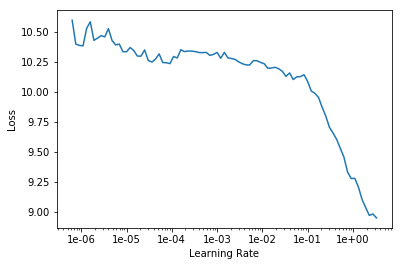

In [20]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1,1e-1)

In [ ]:
learn.save('anime-1')

In [ ]:
learn.data = fc.CollabDataBunch.from_df(ratings, seed=666, valid_pct=0.1, item_name="name",bs=256)

In [ ]:
gc.collect()

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1,3e-3)

In [ ]:
learn.save('anime-2')

In [ ]:
learn.load('anime-2');

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1,1e-3)

In [ ]:
learn.save('anime-3')

In [21]:
learn.load('anime-3');

# Interpretación

Vamos a quedarnos sólo con los 500 animes con más ratings, para tener chance de conocerlos.

Para esto, simplemente vamos a ordenar los animes en base a su número de ratings.

In [22]:
animes_num_ratings = ratings.groupby('name')['rating'].count()

In [23]:
animes_num_ratings.head()

name
&quot;0&quot;                                                         17
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu       1
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi                  635
&quot;Bungaku Shoujo&quot; Memoire                                   662
&quot;Bungaku Shoujo&quot; Movie                                    1295
Name: rating, dtype: int64

In [24]:
animes_num_ratings = animes_num_ratings.sort_values(ascending=False)

In [25]:
animes_num_ratings.head(20)

name
Death Note                            34226
Sword Art Online                      26310
Shingeki no Kyojin                    25290
Code Geass: Hangyaku no Lelouch       24126
Angel Beats!                          23565
Elfen Lied                            23528
Naruto                                22071
Fullmetal Alchemist: Brotherhood      21494
Fullmetal Alchemist                   21332
Code Geass: Hangyaku no Lelouch R2    21124
Toradora!                             20837
Highschool of the Dead                19488
Sen to Chihiro no Kamikakushi         19481
Clannad                               18746
Mirai Nikki (TV)                      18649
Ao no Exorcist                        17801
Steins;Gate                           17151
Another                               17036
Tengen Toppa Gurren Lagann            16955
Soul Eater                            16667
Name: rating, dtype: int64

In [27]:
animes_num_ratings.tail(10)

name
Hi-Speed Jecy                                1
Kinniku Banzuke: Kongou-kun no Daibouken!    1
I Love Sky                                   1
Jiok                                         1
His Lipstick                                 1
Ashita no Eleventachi                        1
Ashita e Mukau Hito                          1
Shounen Ninja Kaze no Fujimaru               1
Hi no Tori: Hagoromo-hen                     1
Mechakko Dotakon                             1
Name: rating, dtype: int64

In [28]:
most_watched = animes_num_ratings.index.values[:500]

In [29]:
most_watched[:10]

array(['Death Note', 'Sword Art Online', 'Shingeki no Kyojin', 'Code Geass: Hangyaku no Lelouch', 'Angel Beats!',
       'Elfen Lied', 'Naruto', 'Fullmetal Alchemist: Brotherhood', 'Fullmetal Alchemist',
       'Code Geass: Hangyaku no Lelouch R2'], dtype=object)

In [30]:
most_watched[-10:]

array(['Gunslinger Girl', 'Ghost in the Shell 2: Innocence', 'Seikon no Qwaser', 'Pokemon: The Origin',
       'Saenai Heroine no Sodatekata', 'Girls Bravo: First Season', 'Another: The Other - Inga', 'Sekaiichi Hatsukoi',
       'Paradise Kiss', 'Little Witch Academia'], dtype=object)

In [31]:
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [32]:
_,anime_names = learn.data.train_ds.x.classes.values()

In [33]:
anime_names

array(['#na#', '&quot;0&quot;', '&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu',
       '&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi', ..., 'xxxHOLiC Movie: Manatsu no Yoru no Yume',
       'xxxHOLiC Rou', 'xxxHOLiC Shunmuki', '◯'], dtype=object)

In [34]:
anime2id = {anime:i for i,anime in enumerate(anime_names)}

In [35]:
anime2id["Death Note"]

1675

In [36]:
most_watched_idx = [anime2id[name] for name in most_watched]

In [39]:
anime_bias = learn.model.i_bias(torch.tensor(most_watched_idx).cuda())

In [44]:
anime_bias = anime_bias.squeeze()

In [45]:
anime_bias[:4]

tensor([1.2207, 0.7204, 1.0468, 1.1249], device='cuda:0',
       grad_fn=<SliceBackward>)

In [46]:
mean_ratings = ratings.groupby("name")['rating'].mean()

In [48]:
mean_ratings.head()

name
&quot;0&quot;                                                       4.764706
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu    1.000000
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi                 7.343307
&quot;Bungaku Shoujo&quot; Memoire                                  7.744713
&quot;Bungaku Shoujo&quot; Movie                                    7.840154
Name: rating, dtype: float64

In [49]:
bias_anime_rating = [(b, a, mean_ratings.loc[a]) for a,b in zip(most_watched,anime_bias)]

In [50]:
bias_anime_rating[:3]

[(tensor(1.2207, device='cuda:0', grad_fn=<SelectBackward>),
  'Death Note',
  8.83462864488985),
 (tensor(0.7204, device='cuda:0', grad_fn=<SelectBackward>),
  'Sword Art Online',
  8.140212846826302),
 (tensor(1.0468, device='cuda:0', grad_fn=<SelectBackward>),
  'Shingeki no Kyojin',
  8.725741399762752)]

Las "buenas" (que tienen poco bias: que aún cuando sus usuarios no califican tan altas las cosas, estas películas tienen buena calificación)

In [53]:
sorted(bias_anime_rating, key=lambda x: x[0], reverse=True)[:15]

[(tensor(1.3908, device='cuda:0', grad_fn=<SelectBackward>),
  'Fullmetal Alchemist: Brotherhood',
  9.32274123011073),
 (tensor(1.2421, device='cuda:0', grad_fn=<SelectBackward>),
  'Steins;Gate',
  9.26132587021165),
 (tensor(1.2207, device='cuda:0', grad_fn=<SelectBackward>),
  'Death Note',
  8.83462864488985),
 (tensor(1.1542, device='cuda:0', grad_fn=<SelectBackward>),
  'Hunter x Hunter (2011)',
  9.234586063929383),
 (tensor(1.1356, device='cuda:0', grad_fn=<SelectBackward>),
  'Code Geass: Hangyaku no Lelouch R2',
  9.059837152054536),
 (tensor(1.1294, device='cuda:0', grad_fn=<SelectBackward>),
  'Clannad: After Story',
  9.165291919061735),
 (tensor(1.1249, device='cuda:0', grad_fn=<SelectBackward>),
  'Code Geass: Hangyaku no Lelouch',
  8.927795739036723),
 (tensor(1.0511, device='cuda:0', grad_fn=<SelectBackward>),
  'Sen to Chihiro no Kamikakushi',
  8.923258559622196),
 (tensor(1.0468, device='cuda:0', grad_fn=<SelectBackward>),
  'Shingeki no Kyojin',
  8.7257413997627

Las "malas"

In [54]:
sorted(bias_anime_rating, key=lambda x: x[0])[:15]

[(tensor(0.1100, device='cuda:0', grad_fn=<SelectBackward>),
  'Amnesia',
  6.637989778534924),
 (tensor(0.1291, device='cuda:0', grad_fn=<SelectBackward>),
  'Highschool of the Dead: Drifters of the Dead',
  6.829015544041451),
 (tensor(0.1381, device='cuda:0', grad_fn=<SelectBackward>),
  'Absolute Duo',
  6.843541202672606),
 (tensor(0.1479, device='cuda:0', grad_fn=<SelectBackward>),
  'Green Green',
  6.6961012135295634),
 (tensor(0.1646, device='cuda:0', grad_fn=<SelectBackward>),
  'Kanokon',
  6.9416610999777335),
 (tensor(0.1697, device='cuda:0', grad_fn=<SelectBackward>),
  'IS: Infinite Stratos 2',
  6.950861667442943),
 (tensor(0.1725, device='cuda:0', grad_fn=<SelectBackward>),
  'School Days',
  6.486360167874857),
 (tensor(0.1773, device='cuda:0', grad_fn=<SelectBackward>),
  'Girls Bravo: First Season',
  6.932243684992571),
 (tensor(0.1834, device='cuda:0', grad_fn=<SelectBackward>),
  'ChäoS;HEAd',
  6.881771150334753),
 (tensor(0.1843, device='cuda:0', grad_fn=<Selec

# Interpretando lo que aprendió la red

Nos cuesta trabajo entender 50 números que representan las preferencias de los usuarios. Tratemos de entender sólo 3 "ejes", usando PCA. Afortunadamente, pytorch trae la función "pca".

In [78]:
most_watched = most_watched[:200]

In [79]:
anime_weights = learn.weight(most_watched, is_item=True)
anime_weights.shape

torch.Size([100, 50])

In [73]:
anime_pca = anime_weights.pca(3)
anime_pca.shape

torch.Size([100, 3])

In [74]:
def altos_y_bajos_en_eje(eje):
    anime_comp = [(f, i) for f,i in zip(anime_pca.t()[eje], most_watched)]
    L = sorted(anime_comp, key=lambda x: x[0], reverse=True)
    return L[:10], L[-10:]

In [75]:
altos_y_bajos_en_eje(0)

([(tensor(1.9133), 'Cowboy Bebop'),
  (tensor(1.6002), 'Baccano!'),
  (tensor(1.4694), 'Bakemonogatari'),
  (tensor(1.4671), 'Mononoke Hime'),
  (tensor(1.4617), 'Neon Genesis Evangelion'),
  (tensor(1.4495), 'FLCL'),
  (tensor(1.4238), 'Fate/Zero 2nd Season'),
  (tensor(1.2642), 'Mahou Shoujo Madoka★Magica'),
  (tensor(1.2380), 'Sen to Chihiro no Kamikakushi'),
  (tensor(1.2363), 'Tengen Toppa Gurren Lagann')],
 [(tensor(-1.1846), 'Dragon Ball GT'),
  (tensor(-1.1995), 'Akame ga Kill!'),
  (tensor(-1.2601), 'Tokyo Ghoul √A'),
  (tensor(-1.2771), 'Vampire Knight Guilty'),
  (tensor(-1.2852), 'Vampire Knight'),
  (tensor(-1.2918), 'High School DxD'),
  (tensor(-1.3320), 'Fairy Tail'),
  (tensor(-1.3881), 'Naruto'),
  (tensor(-1.4183), 'Rosario to Vampire'),
  (tensor(-1.9322), 'Sword Art Online')])

In [76]:
altos_y_bajos_en_eje(1)

([(tensor(1.4150), 'Naruto'),
  (tensor(1.3084), 'Dragon Ball'),
  (tensor(1.3005), 'Dragon Ball Z'),
  (tensor(1.2789), 'Sen to Chihiro no Kamikakushi'),
  (tensor(1.1551), 'Howl no Ugoku Shiro'),
  (tensor(1.1262), 'Fullmetal Alchemist'),
  (tensor(1.0194), 'Tonari no Totoro'),
  (tensor(0.8810), 'Mononoke Hime'),
  (tensor(0.8706), 'Cowboy Bebop'),
  (tensor(0.8426), 'Neon Genesis Evangelion')],
 [(tensor(-0.7429), 'Toradora!'),
  (tensor(-0.7578), 'Sakurasou no Pet na Kanojo'),
  (tensor(-0.7797), 'Boku wa Tomodachi ga Sukunai'),
  (tensor(-0.7947), 'Kami nomi zo Shiru Sekai'),
  (tensor(-0.8481), 'Bakemonogatari'),
  (tensor(-0.8539), 'Ore no Imouto ga Konnani Kawaii Wake ga Nai'),
  (tensor(-0.9083), 'Angel Beats!'),
  (tensor(-0.9684), 'Clannad: After Story'),
  (tensor(-0.9926), 'No Game No Life'),
  (tensor(-1.0675), 'Clannad')])

In [77]:
altos_y_bajos_en_eje(2)

([(tensor(1.3520), 'School Days'),
  (tensor(1.0972), 'Suzumiya Haruhi no Yuuutsu'),
  (tensor(1.0220), 'Lucky☆Star'),
  (tensor(0.9376), 'Chobits'),
  (tensor(0.9330), 'Rosario to Vampire'),
  (tensor(0.7565), 'Vampire Knight'),
  (tensor(0.7420), 'FLCL'),
  (tensor(0.7330), 'Byousoku 5 Centimeter'),
  (tensor(0.7276), 'Full Metal Panic!'),
  (tensor(0.7226), 'Fruits Basket')],
 [(tensor(-0.7499), 'Noragami'),
  (tensor(-0.8093), 'No Game No Life'),
  (tensor(-0.8161), 'Code Geass: Hangyaku no Lelouch R2'),
  (tensor(-0.8780), 'Fullmetal Alchemist: Brotherhood'),
  (tensor(-0.9159), 'Kiseijuu: Sei no Kakuritsu'),
  (tensor(-0.9204), 'Kuroko no Basket'),
  (tensor(-0.9261), 'Shingeki no Kyojin'),
  (tensor(-0.9321), 'Steins;Gate'),
  (tensor(-0.9842), 'Tokyo Ghoul'),
  (tensor(-0.9852), 'One Punch Man')])